# Семинар 7. Метод опорных векторов

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm_bright = ListedColormap(['red', 'blue'])
cm = plt.cm.get_cmap('RdBu')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    if verbose:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE:', rmse)
        print('MAPE:', mape)
        print('R2:  ', r2)
        print()
    
    if plot:
        plt.figure(0, (6, 6))
        plt.scatter(true, pred)
        low = min(true.min(), pred.min())
        high = max(true.max(), pred.max())

        plt.plot([low, high], [low, high], color='blue')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.show()
        
    return (mae, mse, rmse, mape, r2)

In [3]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve)


def classification_metrics(true, pred, prob=None, verbose=False, plot=False):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    roc_auc = roc_auc_score(true, pred)
    
    if verbose:
        print('Accuracy:', acc)
        print('Precision:', prec)
        print('Recall:', rec)
        print('F1-score:', f1)
        print('AUC ROC:', roc_auc)
        print()
    
    if plot:
        assert prob is not None, 'prob should be non-None'
        plt.figure(0, (6, 6))
        fpr, tpr, _ = roc_curve(true, prob[:, 1])
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], ls='--', label='random choice')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-curve')
        plt.legend()
        plt.show()
    return acc, prec, rec, f1, roc_auc

In [4]:
from sklearn import set_config

set_config(display='diagram')

In [5]:
# вспомогательная функция
def plot_classification(X, y, model):
    pred = model.predict(X)
    
    idx = (y == pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='blue', label='true=1, pred=1')

    idx = (y != pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='cyan', label='true=1, pred=0')

    idx = (y == pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='red', label='true=0, pred=0')

    idx = (y != pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='yellow', label='true=0, pred=1')

def plot_decision_map(X, y, model, proba=False):
    X1, X2 = X[:, 0], X[:, 1]
    
    x1_low, x1_high = X1.min(), X1.max()
    x2_low, x2_high = X2.min(), X2.max()
    d1, d2 = x1_high - x1_low, x2_high - x2_low
    
    x1_low -= d1 * 0.1
    x2_low -= d2 * 0.1
    x1_high += d1 * 0.1
    x2_high += d2 * 0.1
    
    
    X1 = np.linspace(x1_low, x1_high, 128)
    X2 = np.linspace(x2_low, x2_high, 128)
    X1, X2 = np.meshgrid(X1, X2)
    Z = np.c_[X1.flatten(), X2.flatten()]
    
    if proba:
        Z = model.predict_proba(Z)[:, 1]
        Z = Z.reshape(X1.shape)
    else:
        Z = model.predict(Z).reshape(X1.shape)

    cmap = cm if proba else cm_bright
    plt.contourf(X1, X2, Z, cmap=cmap, alpha=0.2)
    
def plot_support_vectors(model):
    X = model.support_vectors_
    plt.scatter(X[:, 0], X[:, 1], s=100, edgecolors='black', facecolors='none')
    
def plot_all(X, y, model, proba=False, title=''):
    plot_classification(X, y, model)
    plot_decision_map(X, y, model, proba=proba)
    
    plt.title(title)
    plt.legend()

# 1. Классификация

## 1.1. Случай линейно разделимых данных

In [6]:
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.model_selection import train_test_split

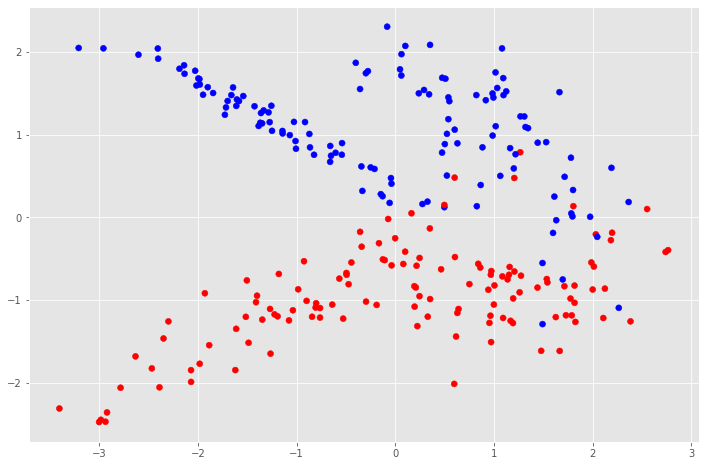

In [7]:
X, y = make_classification(n_samples=256, 
                           n_features=2, 
                           n_informative=2, 
                           n_redundant=0,
                           random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

In [10]:
from sklearn.svm import SVC

model = SVC(kernel='linear', probability=True)
model.fit(X, y)

SVC(kernel='linear', probability=True)

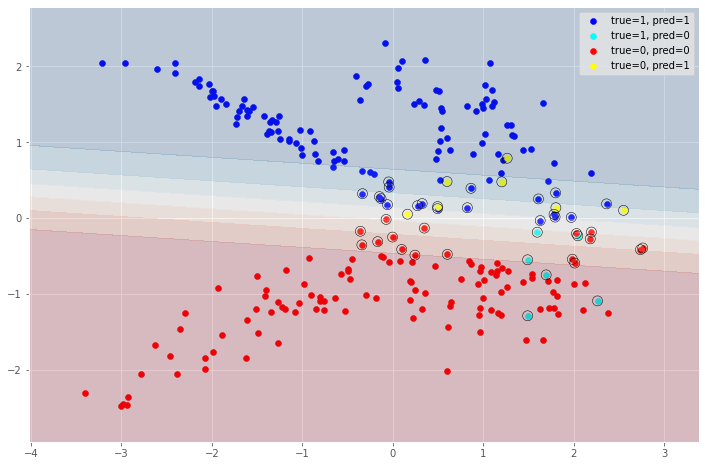

In [11]:
plot_all(X, y, model, proba=True)
plot_support_vectors(model)

# 1.2. Линейно неразделимые данные. Ядерный переход

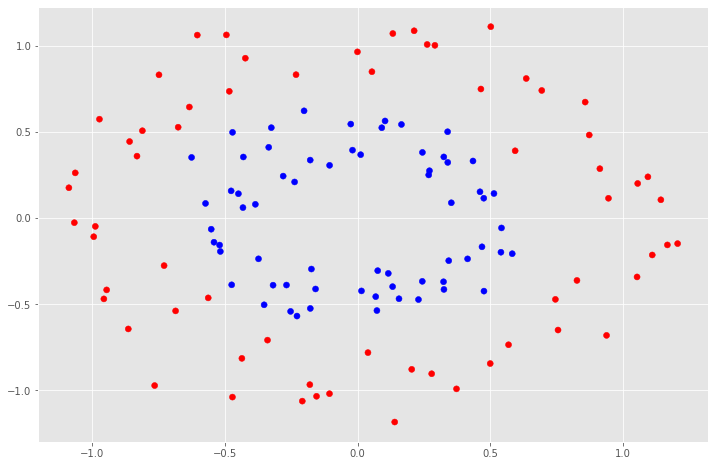

In [12]:
X, y = make_circles(n_samples=128, noise=0.1, factor=0.5,
                  random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

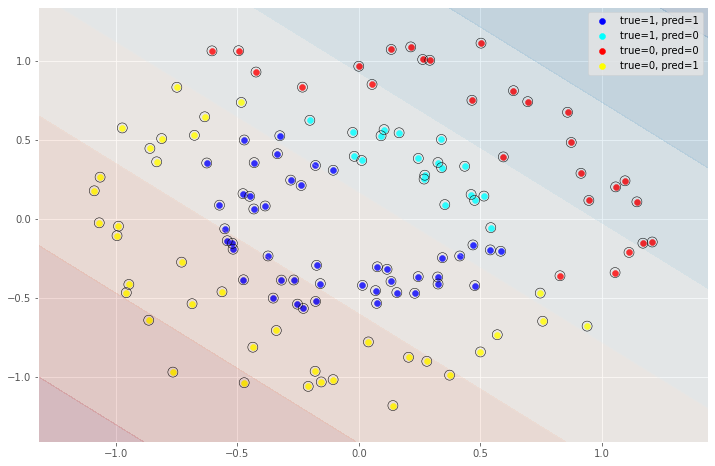

In [13]:
model = SVC(kernel='linear', probability=True)
model.fit(X, y)

plot_all(X, y, model, proba=True)
plot_support_vectors(model)

Воспользуемся ядерным переходом:

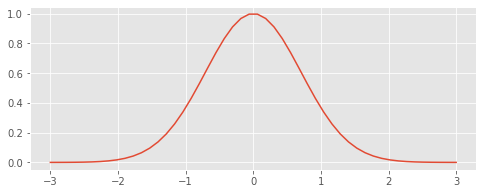

In [14]:
def rbf_1d(x):
    return np.exp(-(x**2))

x_plt = np.linspace(-3, 3)
y_plt = rbf_1d(x_plt)

plt.figure(0, (8, 3))
plt.plot(x_plt, y_plt)
plt.show()

In [15]:
model = SVC(kernel='rbf', probability=True)
model.fit(X, y)

SVC(probability=True)

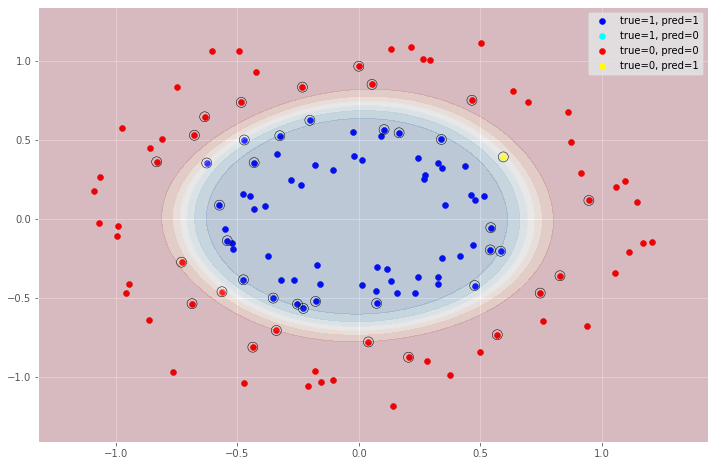

In [16]:
plot_all(X, y, model, proba=True)
plot_support_vectors(model)

Посмотрим на параметры:

In [17]:
import ipywidgets as wg


output = wg.Output()

def func(C, kernel, degree, gamma, shrinking):
    model = SVC(C=C,
                kernel=kernel,
                degree=degree,
                gamma=gamma,
                shrinking=shrinking,
                random_state=42,
                probability=True)
    model.fit(X, y)
    
    with output:
        output.clear_output(wait=True)
        plot_all(X, y, model, proba=True)
        plot_support_vectors(model)
        plt.title(f'C={C}, kernel={kernel}, degree={degree}, gamma={gamma}, shrinking={shrinking}')
        plt.show()
    
wg.interact(func, 
            C=wg.FloatLogSlider(min=-3, max=3, base=10),
            kernel=wg.Select(options=['rbf', 'linear', 'poly', 'sigmoid']),
            degree=wg.IntSlider(min=1, max=8),
            gamma=wg.FloatLogSlider(min=-2, max=2),
            shrinking=wg.Checkbox(),
            countinuous=True)

display(output)

interactive(children=(FloatLogSlider(value=1.0, description='C', max=3.0, min=-3.0), Select(description='kerne…

Output()

# 1.3. Пример: Титаник

* survived -- спасен или нет;
* pclass -- социально-экономический статус (1 -- upper, 2 -- middle, 3 -- lower);
* sex -- пол;
* age -- возраст;
* sibsp -- число ближайших родственников на борту (муж/жена, брат/сестра);
* parch -- число родителей/детей на борту;
* fare -- плата за проезд;
* embarked -- место посадки.

In [18]:
frame = sns.load_dataset('titanic')
frame = frame[['pclass', 'sex', 'age', 'fare', 'survived']].dropna()

print('Shape:', frame.shape)
frame.head()

Shape: (714, 5)


,pclass,sex,age,fare,survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


In [19]:
X = frame[['pclass', 'sex', 'age', 'fare']].copy()
y = frame['survived'].copy()

In [20]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 571
Test size: 143


In [21]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


transformer = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(sparse=False, drop='first'), ['pclass', 'sex'])
)

In [22]:
from sklearn.pipeline import make_pipeline


estimator = SVC(probability=True, random_state=42)
pipeline = make_pipeline(transformer, estimator)

In [23]:
from sklearn.model_selection import GridSearchCV


model = GridSearchCV(pipeline, {
    'svc__kernel': ('rbf', 'linear', 'sigmoid'),
    'svc__gamma': np.logspace(-1, 2, 64),
}, verbose=1, n_jobs=-1)
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['pclass', 'sex'])])),
                ('svc',
                 SVC(gamma=8.961505019466045, probability=True,
                     random_state=42))])

Accuracy: 0.7832167832167832
Precision: 0.7272727272727273
Recall: 0.7142857142857143
F1-score: 0.7207207207207208
AUC ROC: 0.770935960591133



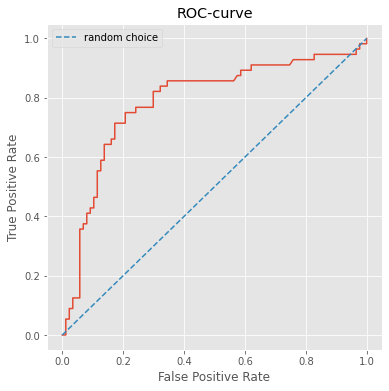

(0.7832167832167832,
 0.7272727272727273,
 0.7142857142857143,
 0.7207207207207208,
 0.770935960591133)

In [25]:
classification_metrics(y_test, 
                       model.predict(X_test), 
                       model.predict_proba(X_test),
                       verbose=True, plot=True)

# 2. Регрессия 

## 2.1. Пример с синтетическими данными

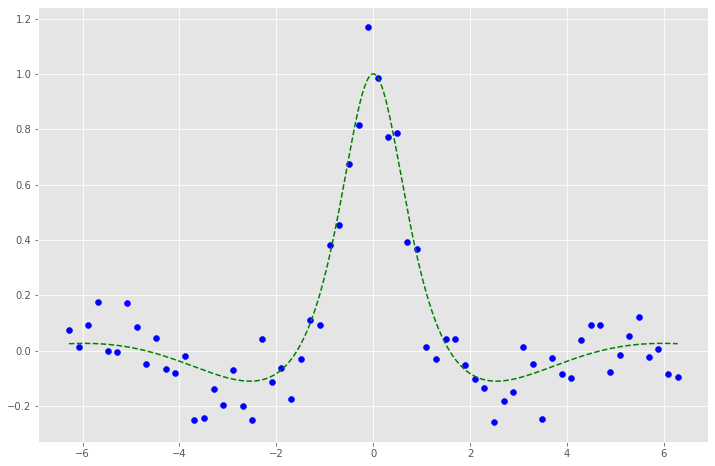

In [26]:
def gt_func(x):
    return np.cos(x) / (np.power(x, 2) + 1)

N = 64
low, high = -2 * np.pi, 2 * np.pi

np.random.seed(42)
X = np.linspace(low, high, N).reshape(-1, 1)
y = gt_func(X[:, 0]) + np.random.normal(scale=0.1, size=N)


x_plt = np.linspace(low, high, 1024)
plt.scatter(X, y, color='blue')
plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
plt.show()

Учим SVM:

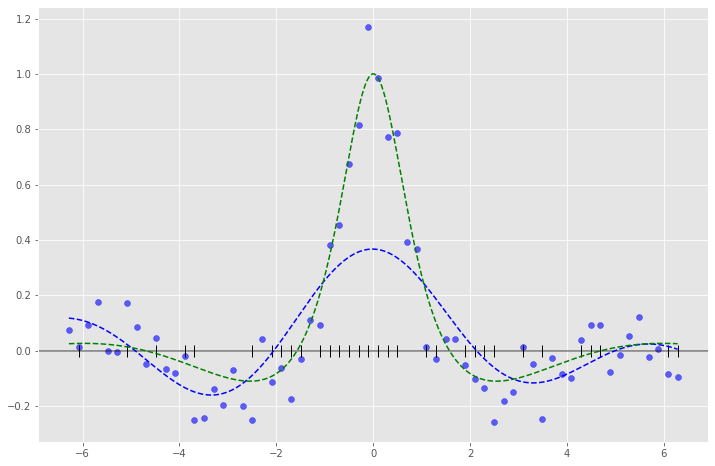

In [27]:
from sklearn.svm import SVR


model = SVR(kernel='rbf')
model.fit(X, y)

y_plt = model.predict(x_plt.reshape(-1, 1))

plt.scatter(X, y, color='blue', alpha=0.6)
plt.axhline(0, color='black', alpha=0.5)
plt.plot(model.support_vectors_, np.zeros_like(model.support_vectors_), '|', markersize=12, color='k')
plt.plot(x_plt, y_plt, ls='--', color='blue')
plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
plt.show()

In [28]:
output = wg.Output()

def func(C, kernel, degree, gamma, shrinking):
    model = SVR(kernel=kernel,
                degree=degree,
                gamma=gamma)
    model.fit(X, y)
    
    with output:
        output.clear_output(wait=True)
        
        y_plt = model.predict(x_plt.reshape(-1, 1))
        plt.scatter(X, y, color='blue', alpha=0.6)
        plt.axhline(0, color='black', alpha=0.5)
        plt.plot(model.support_vectors_, np.zeros_like(model.support_vectors_), '|', markersize=12, color='k')
        plt.plot(x_plt, y_plt, ls='--', color='blue')
        plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
        plt.show()
    
wg.interact(func, 
            C=wg.FloatLogSlider(min=-3, max=3, base=10),
            kernel=wg.Select(options=['rbf', 'linear', 'poly']),
            degree=wg.IntSlider(min=1, max=8),
            gamma=wg.FloatLogSlider(min=-2, max=2),
            shrinking=wg.Checkbox(),
            countinuous=True)

display(output)

interactive(children=(FloatLogSlider(value=1.0, description='C', max=3.0, min=-3.0), Select(description='kerne…

Output()

## 2.2. Пример: расход топлива

Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [38]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


In [39]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

In [40]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


In [41]:
num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(drop='first'), cat_features))
estimator = SVR(kernel='rbf', gamma='auto')
pipeline = make_pipeline(transformer, estimator)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('svr', SVR(gamma='auto'))])

In [46]:
model = GridSearchCV(pipeline, {
    'svr__kernel': ('rbf', 'sigmoid'),
    'svr__gamma': np.logspace(-3, 2, 64),
}, verbose=1, n_jobs=-1)
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('svr', SVR(gamma=0.05572264795507174, kernel='sigmoid'))])

In [49]:
print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True);

Test:
MAE:  0.9293690750362474
MSE:  1.717820855468814
RMSE: 1.310656650488149
MAPE: 0.08023558995679245
R2:   0.8788541081638256

